# HyperLogLog

Каждый элемент хэшируется в битовую строку.

Алгоритм использует массив регистров (обычно 2^b штук).

Первые b бит хэша определяют, в какой регистр записать элемент.

Остальные биты хэша используются для подсчёта количества ведущих нулей + 1.

Если количество ведущих нулей больше текущего значения в регистре, оно обновляется.

На основе значений регистров вычисляется оценка уникальных элементов с использованием гармонического среднего.

In [1]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import math
import matplotlib.pyplot as plt
from collections import defaultdict

In [2]:
def get_hashes(items):
    hashes = []
    
    def generate_binary_hash(seed, length=24):
        np.random.seed(seed)
        binary_string = ''.join(str(np.random.randint(0, 2)) for _ in range(length))
        return binary_string
    
    for item in items:
        seed_value = hash(str(item)) % 20  # Хеш на основе текущего элемента
        hashes.append(generate_binary_hash(seed_value))
    
    return hashes

In [3]:
class HypLog:
    def __init__(self):
        pass
    
    def get_baskets_and_other(self, item, r):
        diction = defaultdict(list)
        for i in item:
            diction[str(i)[:r]].append(str(i)[r:])
        return diction
        
    def find_max_position(self, diction):
        reslist = []
        for key, value in diction.items():
            max_zero = 0
            for j in value:
                m = max_zero_sequence(j)
                if m > max_zero:
                    max_zero = m
            reslist.append(max_zero)
        return reslist
    
    def hyperloglog_estimate(self, buckets, alpha):
        # Сумма 2^(-максимальная_позиция) для всех корзин
        sum_inverse_powers = sum(2 ** -max_position for max_position in buckets)
        
        # Оценка по формуле
        estimate = (len(buckets)**2 * alpha) / sum_inverse_powers
        return estimate
    
    def hyperloglog_error(self,real_number, alg_number):
       return abs((alg_number-real_number)/real_number) *100


def max_zero_sequence(s):
        count = 0
        for char in s:
            if char == '0':
                count += 1
            else:
                break
        return count

In [4]:
def compute_alpha(m):
    """
    Вычисляет коэффициент alpha для HyperLogLog.

    Параметры:
    m (int): Количество корзин (buckets).

    Возвращает:
    float: Значение коэффициента alpha.
    """
    if m <= 0:
        raise ValueError("Количество корзин должно быть положительным числом")
    alpha = 0.7213 / (1 + 1.079 / m)
    return alpha

In [5]:
hyp = HypLog()

#items = ['тополь', 'береза', 'cherry', 'blueberry', 'пион', 'георгин', 'василек']
items = ['1','2','3','4','5','6','7','8','9','10','11','12','13','13','12','12']
hashes = get_hashes(items)
baskets_and_other = hyp.get_baskets_and_other(hashes, r=8)
completion = hyp.find_max_position(baskets_and_other)
estimate = hyp.hyperloglog_estimate(completion, alpha=compute_alpha(len(completion)))
print(f"Оценка количества уникальных элементов: {estimate}")


print(baskets_and_other)
print(completion)

Оценка количества уникальных элементов: 11.2008866915709
defaultdict(<class 'list'>, {'11001111': ['1001011001000100'], '01101111': ['1110010000010110'], '10110001': ['0010100010111101', '0010100010111101'], '01010100': ['0000111100001111'], '00000001': ['0010000001101100', '0010000001101100', '0010000001101100', '0010000001101100'], '00111010': ['0100110111000000'], '00110001': ['1101110110000110', '1101110110000110'], '10111101': ['1010000000001100'], '10101111': ['0101010000100011'], '01100110': ['0011111011000100', '0011111011000100']})
[0, 0, 2, 4, 2, 1, 0, 0, 1, 2]


In [6]:
procent = hyp.hyperloglog_error(real_number=13, alg_number=estimate)
print(f'Процент ошибки = {procent:.2f}%')

Процент ошибки = 13.84%


Таблица зависимости относительной ошибки от числа корзин (m):
N        100        1000       10000      100000
m                                               
16    26.000000  26.000000  26.000000  26.000000
32    18.384776  18.384776  18.384776  18.384776
64    13.000000  13.000000  13.000000  13.000000
128    9.192388   9.192388   9.192388   9.192388
256    6.500000   6.500000   6.500000   6.500000
512    4.596194   4.596194   4.596194   4.596194
1024   3.250000   3.250000   3.250000   3.250000
2048   2.298097   2.298097   2.298097   2.298097


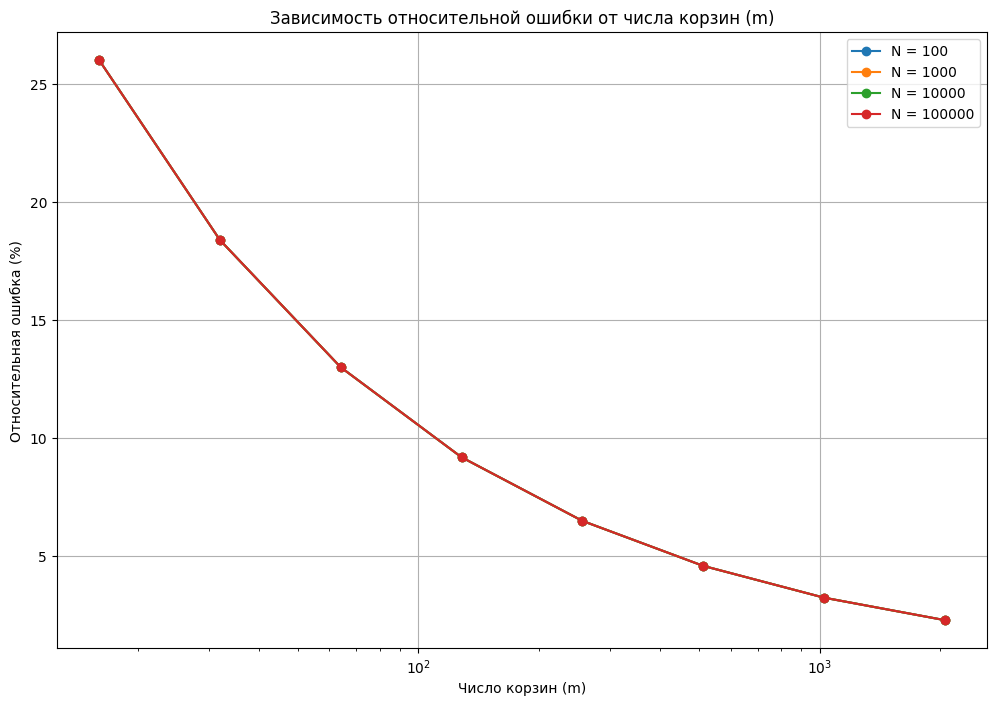

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Функция для расчета относительной ошибки HyperLogLog
def hyperloglog_error(m):
    return 1.04 / np.sqrt(m)

# Генерация данных для анализа
m_values = [16, 32, 64, 128, 256, 512, 1024, 2048]  # Число корзин
n_values = [100, 1000, 10000, 100000]  # Размеры наборов данных

# Создание таблицы для хранения результатов
results = []
for n in n_values:
    for m in m_values:
        error = hyperloglog_error(m)
        results.append({'N': n, 'm': m, 'Относительная ошибка (%)': error * 100})

# Преобразование в DataFrame
df = pd.DataFrame(results)

# Вывод таблицы
print("Таблица зависимости относительной ошибки от числа корзин (m):")
print(df.pivot(index='m', columns='N', values='Относительная ошибка (%)'))

# Построение графиков
plt.figure(figsize=(12, 8))
for n in n_values:
    subset = df[df['N'] == n]
    plt.plot(subset['m'], subset['Относительная ошибка (%)'], label=f'N = {n}', marker='o')

plt.title('Зависимость относительной ошибки от числа корзин (m)')
plt.xlabel('Число корзин (m)')
plt.ylabel('Относительная ошибка (%)')
plt.xscale('log')  # Логарифмическая шкала по оси X
plt.legend()
plt.grid(True)
plt.show()